In [3]:
from pathlib import Path
from IPython.display import display

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import spotipy
import lib_spotify_app.api_adapter as api_adapter

pd.set_option('max_columns', None)

In [4]:
df = pd.read_csv(Path(r'private/data.csv'))

Concatenate the artists values into 1 column for:
* names
* id

In [5]:
df['artists.name'] = df.filter(regex='^artists\.\d+\.name').apply(lambda x: x.dropna().to_list(), axis=1)
df['artists.id'] = df.filter(regex='^artists\.\d+\.id').apply(lambda x: x.dropna().to_list(), axis=1)
df['duration_min'] = df['duration_ms'] / 60000

 Let's retrieve the most useful column for our analysis like:
 * related to music features
 * to classify it (name, etc...)
 * release date (could be related to a specific era)

In [6]:
col = [
    'added_at',
    'album.id',
    'album.images.0.height',
    'album.images.0.url',
    'album.images.0.width',
    'album.name',
    'album.release_date',
    'album.release_date_precision',
    'artists.id',
    'artists.name',
    'duration_min',
    'id',
    'external_urls.spotify',
    'name',
    'popularity',
    'preview_url',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature'
]

feat = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
]

Let's have a general view of the kind of music I listen to

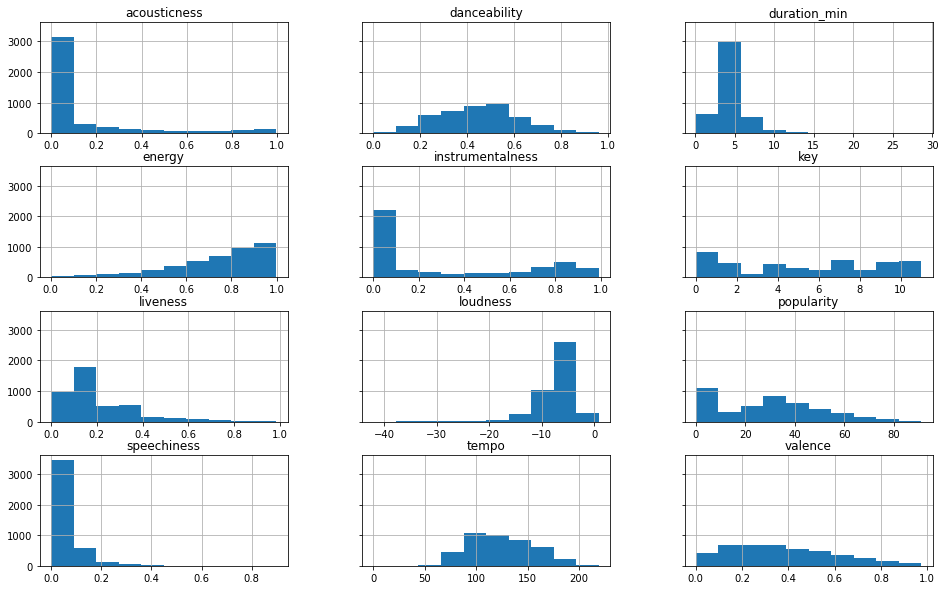

In [10]:
df[feat+['duration_min', 'popularity']].hist(sharey=True, figsize=(16, 10));

There is more 10 audio features given by Spotify, to view our songs in 1 view, I will apply a dimensionnality reduction algorithm to project in a 2D plane.
After that I will cluster on this plane.
Then we can see if the clustering make sense...

For T-SNE I applied 2 methods:
    * scaled the data and apply euclidian
    * apply mahalanobis distance aside and use it as a pre-calculated distance
Clearly, the mahalanobis distance gives better result (as it focus on group of data in similar distribution)

I tune the perplexity = n^(1/2) with n the number of observations (as KNN rule of thumbs)

In [13]:
from sklearn.preprocessing import minmax_scale
normalized = df[feat].apply(lambda x: (x - x.mean()) / x.std())
# normalized = df[feat].apply(minmax_scale)

In [18]:
from scipy.spatial.distance import pdist, squareform
mahalanobis_dist = squareform(pdist(df[feat], metric='mahalanobis'))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 4301 samples in 0.020s...
[t-SNE] Computed neighbors for 4301 samples in 0.223s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4301
[t-SNE] Computed conditional probabilities for sample 2000 / 4301
[t-SNE] Computed conditional probabilities for sample 3000 / 4301
[t-SNE] Computed conditional probabilities for sample 4000 / 4301
[t-SNE] Computed conditional probabilities for sample 4301 / 4301
[t-SNE] Mean sigma: 0.443864
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.159210
[t-SNE] KL divergence after 10000 iterations: 1.848570


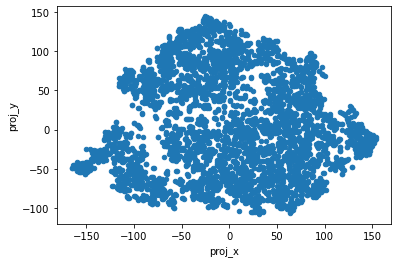

In [25]:
from sklearn.manifold import TSNE

mdl_proj = TSNE(
    perplexity=20,
    n_jobs=3,
    n_iter=10**4,
    n_iter_without_progress=10**3,
    verbose=1,
    metric='precomputed'
)

df[['proj_x', 'proj_y']] = pd.DataFrame(mdl_proj.fit_transform(mahalanobis_dist))
df[['proj_x', 'proj_y']].plot(kind='scatter', x='proj_x', y='proj_y');

In [26]:
from umap import UMAP
mdl_proj = UMAP(n_neighbors=30, metric='mahalanobis')

df[['proj_x', 'proj_y']] = pd.DataFrame(mdl_proj.fit_transform(df[feat]))
df[['proj_x', 'proj_y']].plot(kind='scatter', x='proj_x', y='proj_y');

TypeError: a bytes-like object is required, not 'list'

I fine-tuned HDBSCAN with the min_cluster_size and let min_samples be found
min_cluster_size should be similar to an album size (10-20) or a playlist size (50-100)
the size of 16 seems the magic (other size around does not give similar clusters number and size)

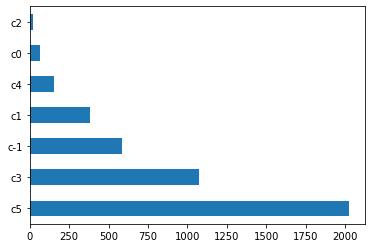

In [67]:
from hdbscan import HDBSCAN

df['clusters'] = HDBSCAN(min_cluster_size=16, min_samples=None).fit_predict(df[['proj_x', 'proj_y']], min)
df['clusters'] = df['clusters'].map(lambda x: f'c{x}')

df['clusters'].value_counts().plot(kind='barh')

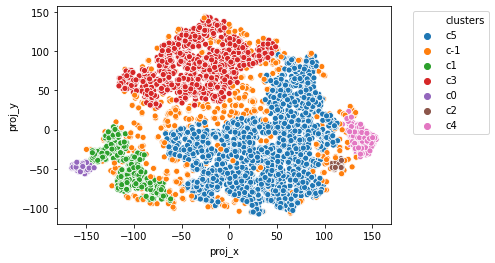

In [68]:
sns.scatterplot('proj_x', 'proj_y', data=df, hue=f'clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')